## Document Image Quality Analysis (DIQA)


Paper: [Sharpness Estimation for Document and Scene Images](https://bit.ly/2N3dWaO)

Generally, Image Quality Analysis(IQA) is divided broadly into two types, 

1. Reference Based Evaluation, 
2. No-Reference Evaluation. 

**Reference Based Sharpness**  | **No-Reference Sharpness** 
:-------------------------:|:-------------------------:
<img src="./images/reference-based-image-eval.jpg" width="400" height="300" />  | <img src="./images/no-ref image.png" width="400" height="300" />

The main difference between these approaches is (1) uses a high quality image to evaluate the quality, while (2) is purely based on image's inherent features(pixels)


Most of the researchers earlier has focused on estimating the quality of natural or scenic images. Document images, however, don't share the same characteristics with scenic images as documents are primarily composed of texts like digitized historical texts, identity documents or bill/receipts etc. Therefore, sharpness measures developed on scenic image might not extend to documents accurately. 

## Blur Types

**Motion Blur**  | **Out of Focus** 
:------------------------- | :-------------------------
<img src="./images/motion-blur.jpg" width="400" height="300" />  | <img src="./images/out-of-focus.jpg" width="400" height="300" />


Authors(Kumar J, et al.) present a very intuitive and simple measure which works on grayscale image, is comparable to state-of-art solution and takes far less time to compute as it doesn't require expensive FFT, canny-edge detection or SVD. It is effective in detecting motion-blur, de-focused images or inherent properties of imaging system.The paper claims to work better than any other perceptually-based, no-reference sharpness measures on [LIVE Dataset](http://live.ece.utexas.edu/research/quality/subjective.htm). 


## Installation
> git clone https://github.com/umang-singhal/pydom.git


In [1]:

# Matrix Operations
import numpy as np

# Computer Vision Library
import cv2


# Visualization
%matplotlib inline
import matplotlib.pyplot as plt



## Base Image Load

Next, we have some basic image load scripts. Here, we read all images as grayscale and apply median filter to it. We also have a normalize method for median filtered image to get it in range of `0 to 1`

In [2]:
def load(imagePath, blur=False, blur_size=(5,5)):    
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    
    # Add Gaussian Blur
    if blur:
        image = cv2.GaussianBlur(image, blur_size, cv2.CV_32F)
    
    Im = cv2.medianBlur(image, 3, cv2.CV_64F).astype("double")/255.0
    return image, Im

# Method to display image matrix
def showImage(image, ax, fig, title, cmap=None):
    im = ax.imshow(image, cmap=cmap)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)

In [3]:
imagePath = "images/hello-world.png"
image, Im = load(imagePath)

## Sharpness Estimation

### $\Delta$DoM
The underlying edge is assumed to be non-linear and hence, can be modeled by a non-parametric model, such as the `difference of differences` that can model changes in the direction of a line. From this model we derive a measure that captures whether the slope changes quickly, a characteristic of sharp edges.

Authors propose to use difference of differences in grayscale values of a median-filtered image ($\Delta$DoM) as an indicator of edge sharpness. Median filtering is used to **smooth variations** due to *noise* while preserving edges. We compute $\Delta$DoM separately for horizontal and vertical directions. 

In the x (horizontal) direction, $\Delta$DoM is:

$$
\Delta DoM_x(i, j) = [Im(i + 2, j) − Im(i, j)] − [Im(i, j) − Im(i − 2, j)]
$$

**Note**: 
1. Im(i, j) is the grayscale value of a pixel located at (i, j) in an image that has been median-filtered
2. We use differences with an offset of `two` which is more robust to intensity variations
3. 

The change in slope, $\Delta$DoM, will be greater for sharp edges, because sharp edges transition to and from a larger slope more quickly. The **absolute value** of the `difference of differences` is taken, since we only care whether the slope changes quickly.

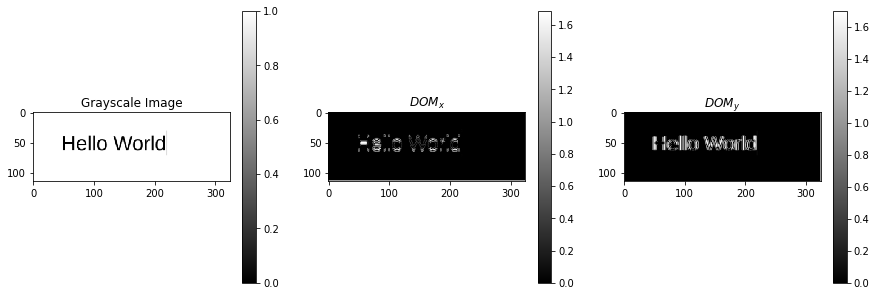

In [4]:
def dom(median_blur_image):

    median_shift_up = np.pad(median_blur_image, ((0,2), (0,0)), 'constant')[2:,:]
    median_shift_down = np.pad(median_blur_image, ((2,0), (0,0)), 'constant')[:-2,:]
    domx = np.abs(median_shift_up - 2*median_blur_image + median_shift_down)
    
    median_shift_left = np.pad(median_blur_image, ((0,0), (0,2)), 'constant')[:,2:]
    median_shift_right = np.pad(median_blur_image, ((0,0), (2,0)), 'constant')[:,:-2]
    domy = np.abs(median_shift_left - 2*median_blur_image + median_shift_right)
    
    return domx, domy
    
    
domx, domy = dom(Im)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
showImage(image/np.max(image), ax1, fig, "Grayscale Image", "gray")
showImage(domx, ax2, fig, "$DOM_x$", "gray")
showImage(domy, ax3, fig, "$DOM_y$", "gray")
# plt.suptitle("Difference of Difference Measure", fontsize=22)
# plt.show()

### $\Delta$DoM and Edge Width

To relate the difference of differences to edge-width, we note that edge-width is inversely proportional to
slope. The change in slope, $\Delta$DoM, is a discrete version of the second derivative. Thus, by integrating the
second derivative, or for our discrete model, summing $\Delta$DoM over a window of size 2w+1, we have a measure that is inversely proportional to edge-width w($e_i$):

$$
\sum_{i-w \le k \le i+w} |\Delta DoM_x(k, j)| \propto \frac {1}{w(e_i)}
$$

Since width of noticeable blur decreases as contrast increases, we need to normalize these quantities with contrast at the edge. The contrast is estimated using the same window of size 2w+ 1 as used for $\Delta$DoM,
around each identified edge at pixel (i, j):

$$
C_x = \sum_{i-w \le k \le i+w} |I(k, j) - I(k-1, j)|
$$

where I(k, j) is the value of a pixel located at (k, j) in the image.

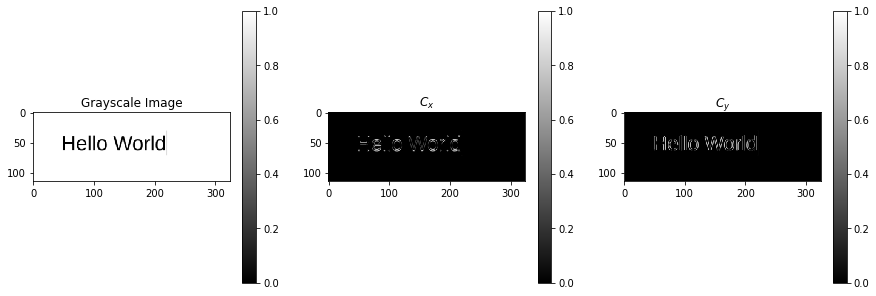

In [5]:
def contrast(Im):
    Cx = np.abs(Im - np.pad(Im, ((1,0), (0,0)), 'constant')[:-1, :])
    Cy = np.abs(Im - np.pad(Im, ((0,0), (1,0)), 'constant')[:, :-1])
    return Cx, Cy

Cx, Cy = contrast(Im)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
showImage(image/np.max(image), ax1, fig, "Grayscale Image", "gray")
showImage(Cx, ax2, fig, "$C_x$", "gray")
showImage(Cy, ax3, fig, "$C_y$", "gray")

### Image Smoothing 
To identify edges quickly, the image is first smoothed with a 1-D filter $\begin{pmatrix}[1/2 & 0 & -1/2]\end{pmatrix}$ in either the x or y direction. The location of absolute values greater than a threshold are chosen to identify probable edge pixels. 

In [6]:
def smoothenImage(gray, transpose = False, epsilon = 1e-8):
    fil = np.array([0.5, 0, -0.5])
    
    if transpose:
        gray = gray.T
        
    gray_smoothed = np.array([np.convolve(gray[i], fil, mode="same") for i in range(gray.shape[0])])
    
    if transpose:
        gray_smoothed = gray_smoothed.T

#     gray_smoothed = convolve1d(gray, fil, mode="constant", axis=transpose) 
    gray_smoothed = np.abs(gray_smoothed)/(np.max(gray_smoothed) + epsilon)
    return gray_smoothed

### Sharpness Measure
The sharpness in the x-direction at a pixel located at (i, j) in an image is computed as:

$$
S_x(i, j) = \frac {\sum_{i-w \le k \le i+w} |\Delta DoM_x(k, j)|} {\sum_{i-w \le k \le i+w} |I(k, j) - I(k-1, j)|}
$$

The ratio exhibits a high value at sharp locations and low values at blurred locations. A similar computation is done to obtain $S_y$(i, j) in the y-direction.

In [7]:

def sharpness_matrix(Im, edgex, edgey, width=2, debug=False):
    
    dodx, dody = dom(Im) #compute_dod(Im)
    Cx, Cy = contrast(Im)
    
    Cx = np.multiply(Cx, edgex)
    Cy = np.multiply(Cy, edgey)
    
    Sx = np.zeros(dodx.shape)
    Sy = np.zeros(dody.shape)
    
    for i in range(width, dodx.shape[0]-width):
        num = np.abs(dodx[i-width:i+width, :]).sum(axis=0)
        dn = Cx[i-width:i+width, :].sum(axis=0)
        Sx[i] = [(num[k]/dn[k] if dn[k] > 1e-3 else 0) for k in range(Sx.shape[1])]
    
    for j in range(width, dody.shape[1]-width):
        num = np.abs(dody[:, j-width: j+width]).sum(axis=1)
        dn = Cy[:, j-width:j+width].sum(axis=1)
        Sy[:, j] = [(num[k]/dn[k] if dn[k] > 1e-3 else 0) for k in range(Sy.shape[0])]
        
    if debug:
        print(f"dodx {dodx.shape}: {[(i,round(np.quantile(dodx, i/100), 2)) for i in range(0, 101, 25)]}")
        print(f"dody {dody.shape}: {[(i,round(np.quantile(dody, i/100), 2)) for i in range(0, 101, 25)]}")
        print(f"Cx {Cx.shape}: {[(i,round(np.quantile(Cx, i/100),2)) for i in range(50, 101, 10)]}")
        print(f"Cy {Cy.shape}: {[(i,round(np.quantile(Cy, i/100),2)) for i in range(50, 101, 10)]}")
        print(f"Sx {Sx.shape}: {[(i,round(np.quantile(Sx, i/100),2)) for i in range(50, 101, 10)]}")
        print(f"Sy {Sy.shape}: {[(i,round(np.quantile(Sy, i/100),2)) for i in range(50, 101, 10)]}")
        
    return Sx, Sy, dodx, dody, Cx, Cy


 ## Final Calculation
 
 We use a threshold of `0.0001` after normalizing by the maximum value in the filtered image. The normalized estimate at each edge-pixel $e_i$ is computed, and the pixel is classified as sharp if it is greater than a pre-defined threshold T.

E.g.
$$
edge_x = \sum (smoothImage_x > 0.0001)
$$

$$
sharp_x = \sum (S_x > T)
$$
 
The sharpness in one direction (i.e., x or y) for either a region or the entire page is computed as:
 
$$
R_x = \frac{sharp_x} {edge_x} 
$$

The sharpness in the x and y directions are combined using a Frobenius-norm to obtain the sharpness for image.
$$
S_I = \sqrt{R_x^2 + R_y^2}
$$

### $S_I$ Range
As $ 0 \le $R_x$, $R_y$ \le 1$, 
$$
0 \le S_I \le \sqrt{2}
$$

In [8]:

def compute_sharpness(Sx, Sy, edgex, edgey, sharpness_threshold=1, debug=False):

    epsilon = 1e-8

    Sx = np.multiply(Sx, edgex)
    n_sharpx = np.sum(Sx >= sharpness_threshold)
    
    Sy = np.multiply(Sy, edgey)
    n_sharpy = np.sum(Sy >= sharpness_threshold)

    n_edgex = np.sum(edgex)
    n_edgey = np.sum(edgey)
    
    Rx = n_sharpx/(n_edgex + epsilon)
    Ry = n_sharpy/(n_edgey + epsilon)

    S = round(np.sqrt(Rx**2 + Ry**2)/np.sqrt(2), 2) * 100
    
    if debug:
        print(f"Sharpness: {S}")
        print(f"Rx: {Rx}, Ry: {Ry}")
        print(f"Sharpx: {n_sharpx}, Sharpy: {n_sharpy}, Edges: {n_edgex, n_edgey}")
    return S

## Done! Lets see how it works

dodx (1029, 1242): [(0, 0.0), (25, 0.0), (50, 0.0), (75, 0.01), (100, 1.97)]
dody (1029, 1242): [(0, 0.0), (25, 0.0), (50, 0.0), (75, 0.13), (100, 1.98)]
Cx (1029, 1242): [(50, 0.0), (60, 0.0), (70, 0.0), (80, 0.0), (90, 0.05), (100, 1.0)]
Cy (1029, 1242): [(50, 0.0), (60, 0.0), (70, 0.0), (80, 0.0), (90, 0.13), (100, 1.0)]
Sx (1029, 1242): [(50, 0.0), (60, 0.0), (70, 0.0), (80, 2.0), (90, 4.22), (100, 765.0)]
Sy (1029, 1242): [(50, 0.0), (60, 0.0), (70, 0.0), (80, 2.0), (90, 8.36), (100, 785.0)]


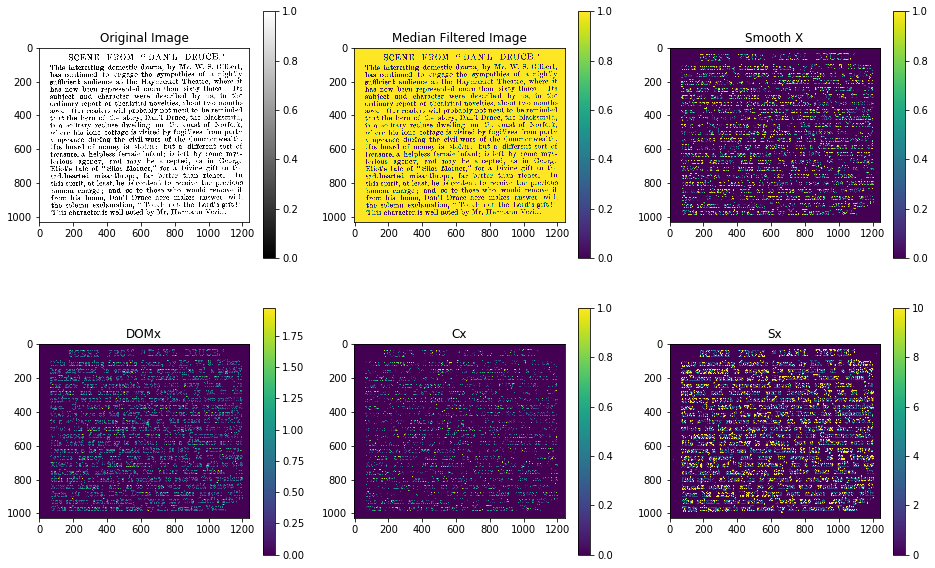

In [21]:


imagePath = "./images/text-img.png"
# imagePath = "./images/blurry-text-1.png"
# imagePath = "./images/blurry-text.jpeg"

width = 1 # 1
edge_threshold = 0.0001
sharpness_threshold = 0.75

r = 2
c = 3

fig, axes = plt.subplots(r,c, figsize=(16, 10))
ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

image, Im = load(imagePath)
showImage(image/255, ax1, fig, "Original Image", "gray")

smoothx = smoothenImage(image, transpose=True)
smoothy = smoothenImage(image)

edgex = smoothx > edge_threshold
edgey = smoothy > edge_threshold

showImage(Im, ax2, fig, f"Median Filtered Image")


Sx, Sy, dodx, dody, Cx, Cy = sharpness_matrix(Im, edgex, edgey, width=width, debug=True)

show = ["x", "y"][0]

if show == "x":

    showImage(smoothx, ax3, fig, "Smooth X")
    showImage(dodx, ax4, fig, "DOMx")
    showImage(Cx, ax5, fig, "Cx")
    Sx = np.clip(Sx, 0, 10)
    showImage(Sx, ax6, fig, "Sx")
    
elif show == "y":
    showImage(smoothy, ax3, fig, "Smooth Y")
    showImage(dody, ax4, fig, "DOMy")
    showImage(Cy, ax5, fig, "Cy")
    Sy = np.clip(Sy, 0, 10)
    showImage(Sy, ax6, fig, "Sy")

plt.show()

In [22]:
score = compute_sharpness(Sx, Sy, edgex, edgey, sharpness_threshold, True)

Sharpness: 82.0
Rx: 0.8049002177696651, Ry: 0.8263355613016338
Sharpx: 301972, Sharpy: 338748, Edges: (375167, 409940)


#### Zoomed Checks

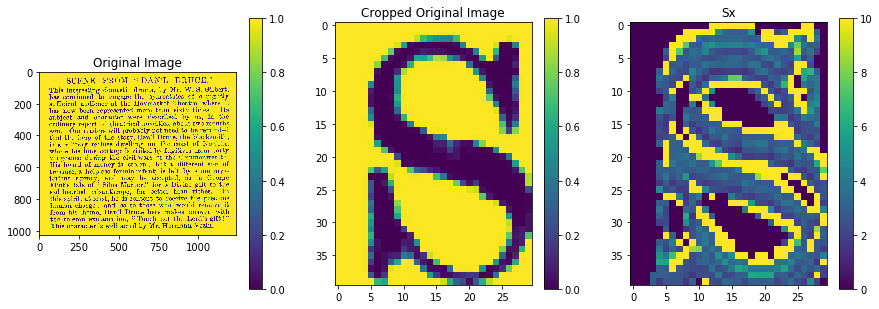

In [12]:


fig2, (ax1 , ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

x1, x2 = 40, 80 
y1, y2 = 170, 200

showImage(image/np.max(image), ax1, fig2, "Original Image")

cropped_image = image[x1:x2, y1:y2]
showImage(cropped_image/np.max(cropped_image), ax2, fig2, "Cropped Original Image")
show = ['x', 'y'][0]

if show == 'x':
    Sx = np.clip(Sx, 0, 10)
    showImage(Sx[x1:x2, y1:y2], ax3, fig2, "Sx")
else:
    Sy = np.clip(Sy, 0, 10)
    showImage(Sy[x1:x2, y1:y2], ax3, fig2, "Sy")


## Results Comparison
<center> <h3>Pair-wise Accuracy (%)</h3> </center>

**Dataset/Approaches**|**JNB**| **CPBD**|**Q** |**DoM**|
---:|:---:|:---:|:---:|:---:
**DocSharp**| 73.0 |51.1 |88.1 |82.6
**LIVE** |99.7 |99.3 |99.5 |97.0
**CSIQ** |96.0 |96.3 |99.6 |92.3


<br><br>
<center> <h3>Computation time in seconds</h3> </center>

**Dataset/Approaches**|**JNB**|**CPBD**|**Q**|**DoM**
---:|:---:|:---:|:---:|:---:
**DocSharp** |33.63 |55.46 |12.36 |3.91
**LIVE** |2.25 |1.05 |0.88 |0.27
**CSIQ** |1.71 |0.68 |0.66 |0.26

## References

[1] R. Ferzli and L. Karam. 
A no-reference objective image sharpness metric based on the notion of just noticeable
blur (jnb). IEEE Tran. on Image Processing, 18:717–728,
2009.

[2] E. C. Larson and D. M. Chandler. Most apparent distortion: full-reference image quality assessment and the role of strategy. Journal of Electronic Imaging, 19(1), 2010.

[3] P. Marziliano, F. Dufaux, S. Winkler, and T. Ebrahimi. A 
no-reference perceptual blur metric. In ICIP, volume 3,
pages 57 – 60, 2002.

[4] N. Narvekar and L. Karam. A no-reference image blur
metric based on the cumulative probability of blur detection (cpbd). IEEE Tran. on Image Processing, 20(9):2678
–2683, 2011.

[5] H. R. Sheikh, Z. Wang, L. Cormack, and A. C. Bovik.
Live image quality assessment database release 2. In
http://live.ece.utexas.edu/research/quality, 2006.

[6] X. Zhu and P. Milanfar. Automatic parameter selection
for denoising algorithms using a no-reference measure of
image content. IEEE Transactions on Image Processing,
19(12):3116 –3132, 2010

## Conclusion

The solution helps detect the sharpness measure effectively in identity documents. This can prove to be very helpful for the users to expedite the onboarding process.